In [392]:
import matplotlib.pyplot as plt

#x = [-125.10482863, -129.83038525, -159.04283509, -154.31646944]
#y = [-370.01790486, -384.56223777, -375.05643893, -360.51151824]
#plt.plot(x, y, 'b.')
#plt.show()
def shift_gfa_points(deltax, deltay):
    import numpy as np
    x = [-125.10482863, -129.83038525, -159.04283509, -154.31646944]
    y = [-370.01790486, -384.56223777, -375.05643893, -360.51151824]
    point1 = [x[2], y[2]]
    point2 = [x[1], y[1]]
    vector1 = [(point2[0] - point1[0]), (point2[1] - point1[1])]
    vector2 = [1, 0]
    # Angle between vector1 and vector 2 using dot product
    angle = np.arccos((np.dot(vector1, vector2))/(np.sqrt((vector1[0]**2) + (vector1[1]**2))))
    
    shiftmat = np.zeros(shape=(2,2))
    shiftmat[0] = [np.cos(angle), -np.sin(angle)]
    shiftmat[1] = [np.sin(angle), np.cos(angle)]
    reverseshift= np.zeros(shape=(2,2))
    reverseshift[0] = [np.cos(angle), np.sin(angle)]
    reverseshift[1] = [-np.sin(angle), np.cos(angle)]
    
    # Shifts the initial coordinates to be parallel to the vector [1, 0]
    coord = np.zeros(shape=(2,1))
    oldxcoord = x
    oldycoord = y
    for i in range(4):
        coord[0] = oldxcoord[i]
        coord[1] = oldycoord[i]
        newcoord = np.matmul(shiftmat, coord)
        oldxcoord[i] = newcoord[0]
        oldycoord[i] = newcoord[1]
        if(i == 0 or i == 1):
            x[i] = newcoord[0] + deltax
        else:
            x[i] = newcoord[0] - deltax
        if(i == 1 or i == 2):
            y[i] = newcoord[1] - deltay
        else:
            y[i] = newcoord[1] + deltay
    oldxcoord = x
    oldycoord = y
    for i in range(4):
        coord[0] = oldxcoord[i]
        coord[1] = oldycoord[i]
        newcoord = np.matmul(reverseshift, coord)
        oldxcoord[i] = newcoord[0]
        oldycoord[i] = newcoord[1]
        x[i] = newcoord[0]
        y[i] = newcoord[1]
    
    rotatemat = np.zeros(shape=(2,2))
    rotatemat[0] = [np.cos(np.radians(36)), -np.sin(np.radians(36))]
    rotatemat[1] = [np.sin(np.radians(36)), np.cos(np.radians(36))]
    return find_new_gfa_coordinates(x, y, rotatemat)

def find_new_gfa_coordinates(x, y, rotatemat):
    import numpy as np
    x_all = np.zeros(shape=(40,1))
    y_all = np.zeros(shape=(40,1))
    coord = np.zeros(shape=(2,1))
    gfacoord = np.zeros(shape=(4, 2))
    oldxcoord = x
    oldycoord = y
    counter = 0
    for j in range(10):
        for i in range(4):
            coord[0] = oldxcoord[i]
            coord[1] = oldycoord[i]
            newcoord = np.matmul(rotatemat, coord)
            oldxcoord[i] = newcoord[0]
            oldycoord[i] = newcoord[1]
            gfacoord[i] = [newcoord[0], newcoord[1]]
            x_all[counter] = newcoord[0]
            y_all[counter] = newcoord[1]
            counter += 1
    #print(x_all, y_all)
    return x_all, y_all
    
#x, y = shift_gfa_points(50, 50)
#plt.plot(x, y, 'g.')



In [393]:
def degrees2xytolerance(degrees_tolerance):
    import desimodel.io
    import scipy.interpolate
    platescale = desimodel.io.load_platescale()
    fn = scipy.interpolate.interp1d(platescale['radius'], platescale['radial_platescale'], kind = 'quadratic')
    fn1 = scipy.interpolate.interp1d(platescale['radius'], platescale['az_platescale'], kind = 'quadratic')
    # Center of a given GFA from DESI-0530-v13 Excel Spreadsheet
    x = 333.738
    y = 217.766
    radius = np.sqrt(x**2 + y**2)
    # Platescales are in units of microns per arcsecond
    r_ps = fn(radius)
    az_ps = fn(radius)
    x_tolerance = degrees_tolerance / (10**3) * 3600 * r_ps
    y_tolerance = degrees_tolerance / (10**3) * 3600 * az_ps
    return x_tolerance, y_tolerance

In [394]:
def is_on_gfa_test(targetx, targety, degrees_tolerance):
    import desimodel.footprint
    #import desimodel.io
    # If any calculated area is under the threshold area, it is mathematically impossible
    THRESHOLD_AREA = 469.7
    MIN_TOLERANCE = 0.001
    # The area boundary's value is the area of the gfa plus some tolerance. 
    x_tolerance, y_tolerance = degrees2xytolerance(degrees_tolerance)
    
    #AREA_BOUNDARY = 469.8037221 + MIN_TOLERANCE
    targetindices = []
    #gfatable = desimodel.io.load_gfa()
    
    # x and y hold the 40 new GFA coordinates
    x, y = shift_gfa_points(x_tolerance, y_tolerance)
    AREA_BOUNDARY = retrieve_minimum_boundary(x_tolerance, y_tolerance) + MIN_TOLERANCE
    
    targetx = np.asarray(targetx)
    targety = np.asarray(targety)
    # Method to check if point is inside the rectangle
    for gfaid in range(0, 40, 4):
        # a1 through a4 are edge lengths of the rectangle formed by corners of the GFAs
        a1 = np.sqrt((x[gfaid] - x[gfaid + 1])**2
                    + (y[gfaid] - y[gfaid + 1])**2)
        a2 = np.sqrt((x[gfaid + 1] - x[gfaid + 2])**2
                    + (y[gfaid + 1] - y[gfaid + 2])**2)
        a3 = np.sqrt((x[gfaid + 2] - x[gfaid + 3])**2
                    + (y[gfaid + 2] - y[gfaid + 3])**2)
        a4 = np.sqrt((x[gfaid + 3] - x[gfaid])**2
                    + (y[gfaid + 3] - y[gfaid])**2)
        # b1 through b4 are the line segments from each corner to the target location
        b1 = np.sqrt((x[gfaid] - targetx)**2
                    + (y[gfaid] - targety)**2)
        b2 = np.sqrt((x[gfaid + 1] - targetx)**2
                    + (y[gfaid + 1] - targety)**2)
        b3 = np.sqrt((x[gfaid + 2] - targetx)**2
                    + (y[gfaid + 2] - targety)**2)
        b4 = np.sqrt((x[gfaid + 3] - targetx)**2
                    + (y[gfaid + 3] - targety)**2)
        # Calculating areas of triangles using Heron's Formula
        #gfaarea = a1 * a2
        #gfaarea2 = a2 * a3
        u1 = (a1 + b1 + b2) / 2.0
        u2 = (a2 + b2 + b3) / 2.0
        u3 = (a3 + b3 + b4) / 2.0
        u4 = (a4 + b4 + b1) / 2.0
        area1 = np.sqrt(u1 * (u1 - a1) * (u1 - b1) * (u1 - b2))
        area2 = np.sqrt(u2 * (u2 - a2) * (u2 - b2) * (u2 - b3))
        area3 = np.sqrt(u3 * (u3 - a3) * (u3 - b3) * (u3 - b4))
        area4 = np.sqrt(u4 * (u4 - a4) * (u4 - b4) * (u4 - b1))
        targetarea = area1 + area2 + area3 + area4
        
        assert np.all(targetarea > THRESHOLD_AREA)
        #use np.where!!!!!!!!!
        # This if statement may be redundant and thus unnecessary
        if(any(targetarea < AREA_BOUNDARY) and all(targetarea > THRESHOLD_AREA)):
            print("The target is on GFA", int(gfaid / 4))  
            newtargetindices = np.where(targetarea < AREA_BOUNDARY)
            targetindices.append(newtargetindices[0])
    """targetindices is an array of targets with their respective indices in the 
    RA and Dec list passed in that fall on certain GFAs denoted by the index 
    in the targetindices array."""
    #print(gfatable['X'], gfatable['Y'])
    return targetindices


The target is on GFA 0
The target is on GFA 0


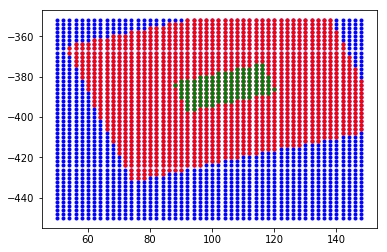

In [395]:
import matplotlib.pyplot as plt
import numpy as np
#telra and teldec = 7.11 -10.53

miny = -450
maxy = -350
minx = 50
maxx = 150
x = []
y = []
import desimodel.focalplane
import desimodel.footprint

while miny < maxy:
    startx = minx
    while startx < maxx:
        x.append(startx)
        y.append(miny)
        startx += 2
    miny += 2

#import desimodel.io
#tiles = desimodel.io.load_tiles()
x = np.asarray(x)
y = np.asarray(y)

# TYPE HERE TO TEST THE CODE FOR CHANGING GFA BOUNDARIES USING DEGREES_TOLERANCE
targetindices = is_on_gfa_test(x, y, .1)
#print(targetindices)
plt.plot(x, y, 'b.')
for gfaid in targetindices:
    for indices in gfaid:
        plt.plot(x[indices], y[indices], 'r.')


        
targetindices = is_on_gfa_test(x, y, 0)
for gfaid in targetindices:
    for indices in gfaid:
        plt.plot(x[indices], y[indices], 'g.')
        
plt.show()


In [396]:
#6.644525362152656, -9.055425745149217 GUARANTEED TO BE IN GFA (RA, DEC)
def retrieve_minimum_boundary(x_tolerance, y_tolerance):
    import desimodel.footprint
    import desimodel.focalplane
    
    targetx = 116.279135121
    targety = -372.885546514
    #x, y = desimodel.focalplane.radec2xy(7.11, -10.53, targetx, targety)
    #print(x, y)
    # If any calculated area is under the threshold area, it is mathematically impossible
    THRESHOLD_AREA = 469.7
    MIN_TOLERANCE = 0.001
    # The area boundary's value is the area of the gfa plus some tolerance. 
    
    # x and y hold the 40 new GFA coordinates
    x, y = shift_gfa_points(x_tolerance, y_tolerance)
    
    targetx = np.asarray(targetx)
    targety = np.asarray(targety)
    #print(targetx)
    # Method to check if point is inside the rectangle
    for gfaid in range(0, 4, 4):
        # a1 through a4 are edge lengths of the rectangle formed by corners of the GFAs
        a1 = np.sqrt((x[gfaid] - x[gfaid + 1])**2
                    + (y[gfaid] - y[gfaid + 1])**2)
        a2 = np.sqrt((x[gfaid + 1] - x[gfaid + 2])**2
                    + (y[gfaid + 1] - y[gfaid + 2])**2)
        a3 = np.sqrt((x[gfaid + 2] - x[gfaid + 3])**2
                    + (y[gfaid + 2] - y[gfaid + 3])**2)
        a4 = np.sqrt((x[gfaid + 3] - x[gfaid])**2
                    + (y[gfaid + 3] - y[gfaid])**2)
        # b1 through b4 are the line segments from each corner to the target location
        b1 = np.sqrt((x[gfaid] - targetx)**2
                    + (y[gfaid] - targety)**2)
        b2 = np.sqrt((x[gfaid + 1] - targetx)**2
                    + (y[gfaid + 1] - targety)**2)
        b3 = np.sqrt((x[gfaid + 2] - targetx)**2
                    + (y[gfaid + 2] - targety)**2)
        b4 = np.sqrt((x[gfaid + 3] - targetx)**2
                    + (y[gfaid + 3] - targety)**2)
        # Calculating areas of triangles using Heron's Formula
        #gfaarea = a1 * a2
        #gfaarea2 = a2 * a3
        u1 = (a1 + b1 + b2) / 2.0
        u2 = (a2 + b2 + b3) / 2.0
        u3 = (a3 + b3 + b4) / 2.0
        u4 = (a4 + b4 + b1) / 2.0
        area1 = np.sqrt(u1 * (u1 - a1) * (u1 - b1) * (u1 - b2))
        area2 = np.sqrt(u2 * (u2 - a2) * (u2 - b2) * (u2 - b3))
        area3 = np.sqrt(u3 * (u3 - a3) * (u3 - b3) * (u3 - b4))
        area4 = np.sqrt(u4 * (u4 - a4) * (u4 - b4) * (u4 - b1))
        targetarea = area1 + area2 + area3 + area4
        
        assert np.all(targetarea > THRESHOLD_AREA)
        #print(targetarea)
        return targetarea
        
    """targetindices is an array of targets with their respective indices in the 
    RA and Dec list passed in that fall on certain GFAs denoted by the index 
    in the targetindices array."""
    #print(gfatable['X'], gfatable['Y'])
    #return targetindices

area = retrieve_minimum_boundary(0, 0)
print(area)
# CODE IS QUITE REDUNDANT AND SHOULD BE CLEANED UP BUT IS USED FOR TESTING RIGHT NOW

[ 469.80372211]
